In [23]:
# import the necessary libraries
import re
import requests
import random
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import gridspec
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
from time import sleep
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import math

# global properties
data_dir = "data/" # where to save data
# num_search_pages = 50 # how many search pages to cull through

# NOTE:
# if you haven't yet downloaded the data, this should be set to True
download_data = False

In [112]:
# Import data from .csv file
world_stringency_fname = os.path.join(data_dir,
                     "OxCGRT_latest.csv")
world_stringency_df = pd.read_csv(world_stringency_fname)


# Import world data to get test info
world_covid_fname = os.path.join("data/1_owid",
                     "owid-covid-data.csv")
world_covid_df = pd.read_csv(world_covid_fname)

# copy over locations from other notebook
locations_w_test_data = ['Argentina', 'Australia', 'Austria', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Malta', 'Mauritania', 'Mexico', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Switzerland', 'Taiwan', 'Thailand', 'Togo', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Vietnam', 'Zambia', 'Zimbabwe']
locations_w_test_data_df = world_stringency_df[world_stringency_df["CountryName"].isin(locations_w_test_data)]
world_covid_data_df = world_covid_df[world_covid_df["location"].isin(locations_w_test_data)]


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [113]:
features = ['C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag']
additional_features = ['stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index']

In [114]:
# Processing for Stringency Data: Fill in NaN values and drop unnecessary columns
locations_imp_df = locations_w_test_data_df.interpolate(method ='linear', limit_direction ='both')
locations_imp_df.drop(columns=["M1_Wildcard"]) # This is a catch all notes comment but has no vales for our country set

# Processing for World Data: Interpolate missing total_tests
world_imp_df = pd.DataFrame(columns=world_covid_data_df.columns)

for loc in locations_w_test_data:
    loc_df = world_covid_data_df[world_covid_data_df["location"]==loc]
    loc_df_imp = loc_df.copy();
    num_missing = loc_df["total_tests"].isna().sum()
    if num_missing>0:
        total_tests_interp = loc_df["total_tests"].interpolate(method ='linear', limit_direction ='both')
        loc_df_imp["total_tests"] = total_tests_interp;
        # assemble df
        world_imp_df = world_imp_df.append(loc_df_imp)

# update positive test rates
pos_rate_pre = world_covid_data_df["positive_rate"].values
pos_rate_aft = world_imp_df["new_cases_smoothed"]/(world_imp_df["new_tests_smoothed"])
# drop 0s and 1s
pos_rate_aft[pos_rate_aft<0] =math.nan
pos_rate_aft[pos_rate_aft>1] =math.nan
world_imp_df["imp_positive_rate"] = pos_rate_aft;
print("Number of missing positive rates before filling in is:", np.count_nonzero(np.isnan(pos_rate_pre)), 
      "after fill in is:", np.count_nonzero(np.isnan(pos_rate_aft))) 

Number of missing positive rates before filling in is: 5858 after fill in is: 4723


In [115]:
# What features might be good predictors of confirmed cases?
world_imp_df = world_imp_df.fillna(0) # fill nans w 0 - around 4000/18000 are 0s now

# Join both DFs so we have positive rate info to predict
if "-" not in locations_imp_df["Date"].iloc[0]:
    locations_imp_df["Date"] = locations_imp_df["Date"].apply(
        lambda row : str(row)[0:4]+"-"+str(row)[4:6]+"-"+str(row)[6:]) 
world_imp_df.rename(columns={'location': 'CountryName', 'date': 'Date'}, inplace=True)
combined_df = locations_imp_df.merge(world_imp_df, how="inner", on=["CountryName", "Date"])

In [126]:
combined_df.describe()

C1_School closing       C1_Flag  C2_Workplace closing       C2_Flag  \
count       64231.000000  64231.000000          64231.000000  64231.000000   
mean            2.151443      0.731478              1.637306      0.738558   
std             1.032774      0.432620              0.931492      0.428416   
min             0.000000      0.000000              0.000000      0.000000   
25%             1.189024      0.096535              1.000000      0.323387   
50%             3.000000      1.000000              2.000000      1.000000   
75%             3.000000      1.000000              2.000000      1.000000   
max             3.000000      1.000000              3.000000      1.000000   

       C3_Cancel public events       C3_Flag  C4_Restrictions on gatherings  \
count             64231.000000  64231.000000                   64231.000000   
mean                  1.548486      0.831704                       2.802144   
std                   0.684263      0.366383                       1.415479   
min                   0.000000      0.000000                       0.000000   
25%                   1.000000      1.000000                       2.000000   
50%                   2.000000      1.000000                       3.000000   
75%                   2.000000      1.000000                       4.000000   
max                   2.000000      1.000000                       4.000000   

            C4_Flag  C5_Close public transport       C5_Flag  ...  \
count  64231.000000               64231.000000  64231.000000  ...   
mean       0.765892                   0.640627      0.582022  ...   
std        0.413480                   0.688894      0.457689  ...   
min        0.000000                   0.000000      0.000000  ...   
25%        0.823765                   0.000000      0.000000  ...   
50%        1.000000                   1.000000      0.911661  ...   
75%        1.000000                   1.000000      1.000000  ...   
max        1.000000                   2.000000      1.000000  ...   

       extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
count     64231.000000           64231.000000         64231.000000   
mean          4.378929             184.266603             8.376909   
std          11.469788              82.134652             2.964772   
min           0.000000              79.370000             0.000000   
25%           0.500000             151.089000             6.740000   
50%           1.200000             151.089000             8.110000   
75%           3.400000             197.093000            10.790000   
max          77.600000             539.849000            17.720000   

       female_smokers  male_smokers  handwashing_facilities  \
count    64231.000000  64231.000000            64231.000000   
mean        13.301633     24.844373               11.112270   
std          8.197731     11.623883               25.789331   
min          0.000000      0.000000                0.000000   
25%          7.000000     17.900000                0.000000   
50%         12.000000     24.600000                0.000000   
75%         19.100000     28.300000                0.000000   
max         37.700000     76.100000               98.999000   

       hospital_beds_per_thousand  life_expectancy  human_development_index  \
count                64231.000000     64231.000000             64231.000000   
mean                     2.798065        76.951834                 0.818115   
std                      1.908388         5.297200                 0.139495   
min                      0.000000        54.690000                 0.000000   
25%                      2.200000        75.880000                 0.759000   
50%                      2.600000        78.860000                 0.870000   
75%                      2.770000        78.860000                 0.924000   
max                     13.050000        84.630000                 0.953000   

       imp_positive_rate  
count       64231.000000  
mean 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_misc.py:100: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


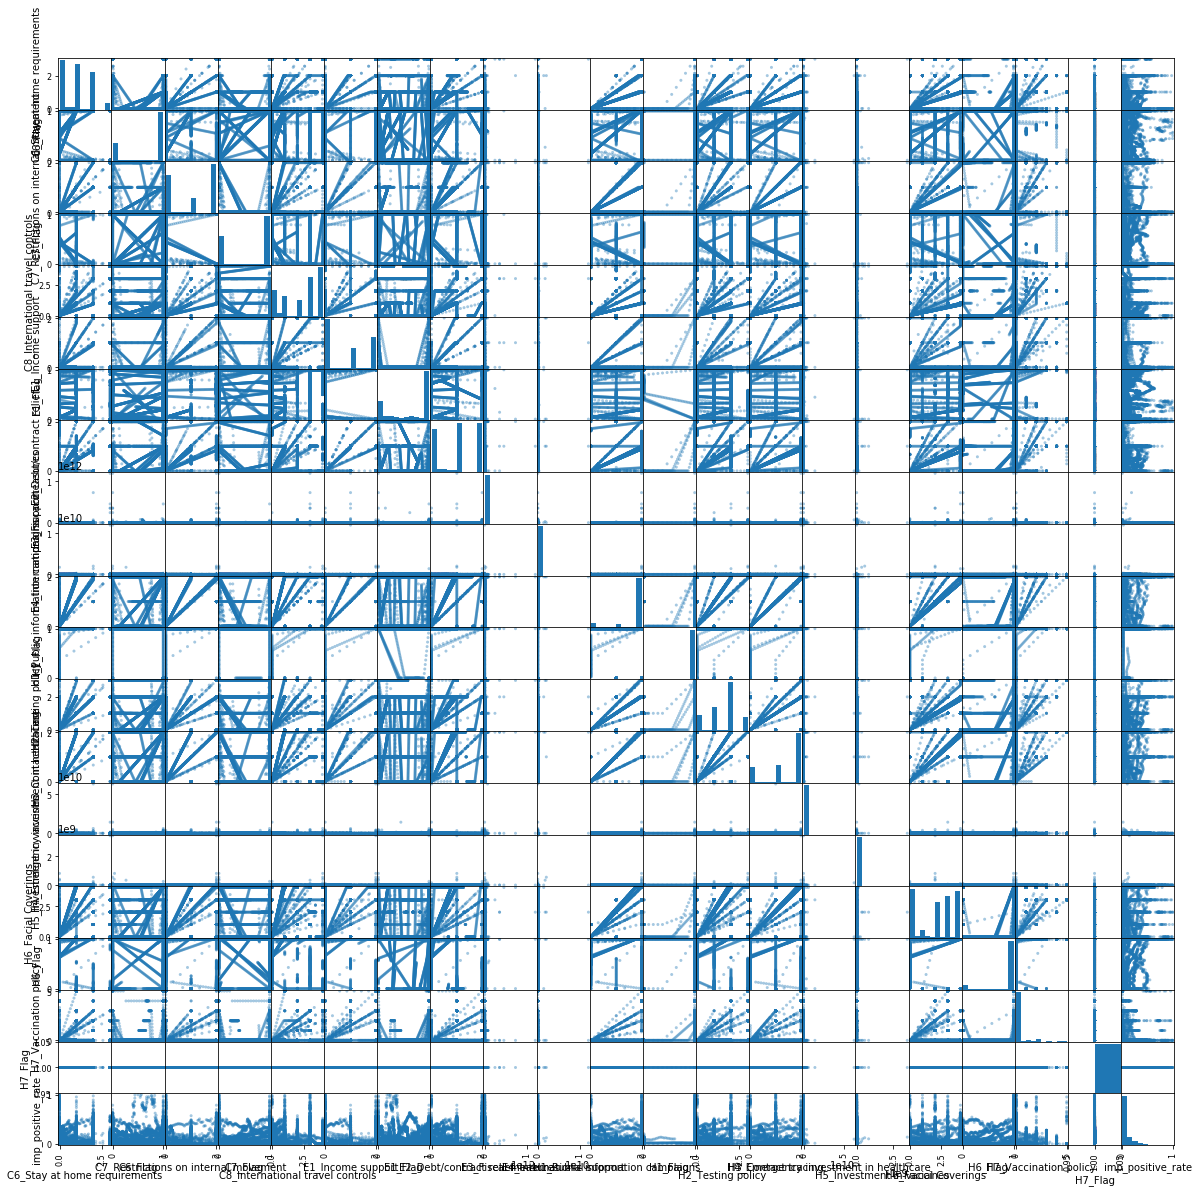

In [7]:
grid_features = features[10:] + ['imp_positive_rate']

scatter = pd.plotting.scatter_matrix(combined_df[grid_features], alpha=0.4, figsize=(20,20))
# for ax in scatter.ravel():
#     ax.set_xlabel(ax.get_xlabel(), rotation = 90)
#     ax.set_ylabel(ax.get_ylabel(), rotation = 90)

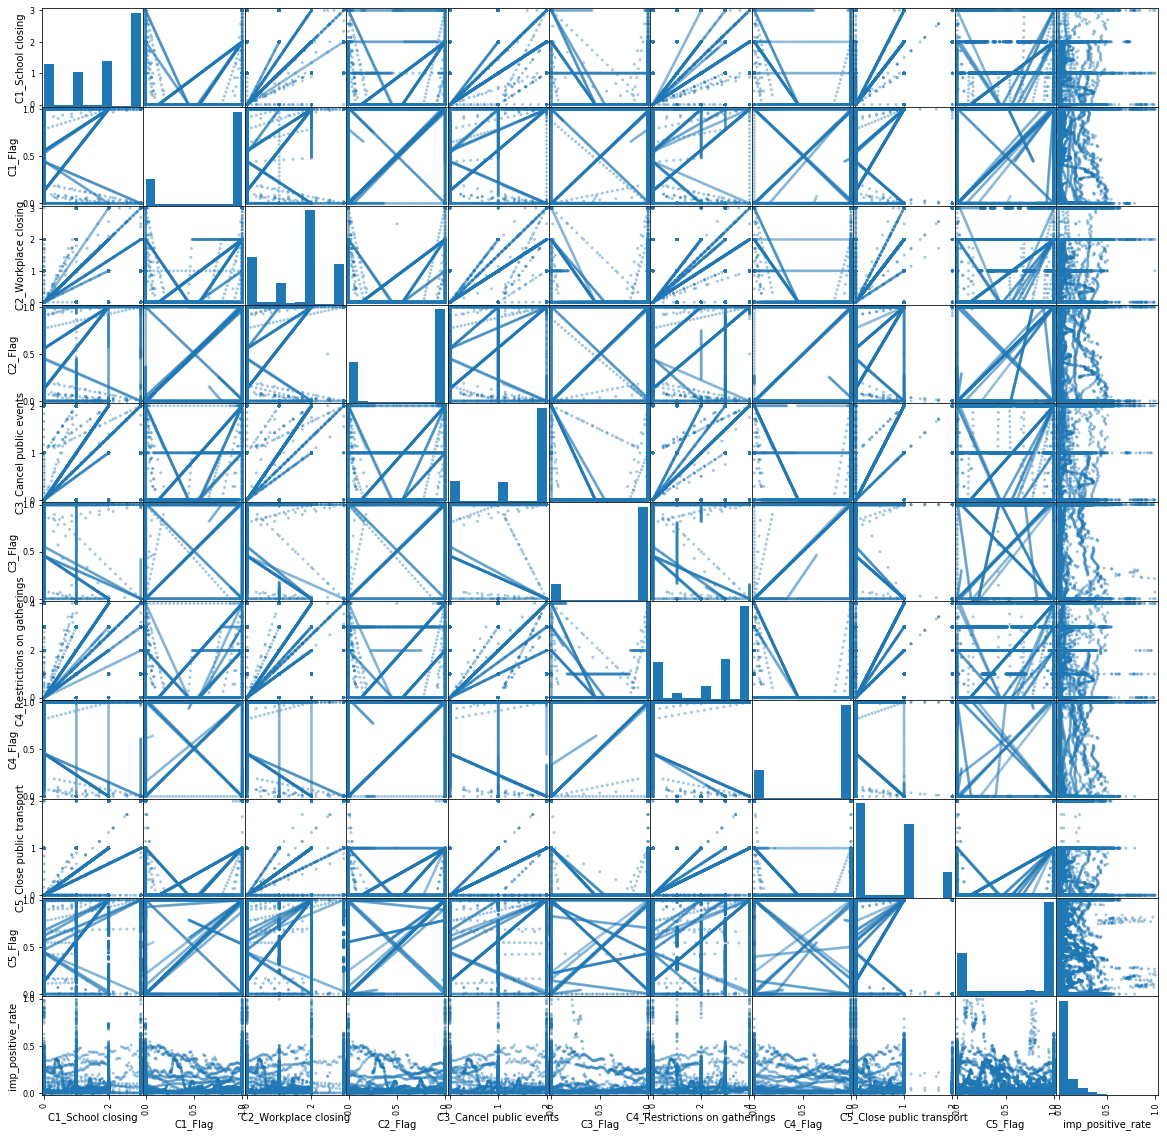

In [7]:
grid_features = features[0:10] + ['imp_positive_rate']

scatter = pd.plotting.scatter_matrix(combined_df[grid_features], alpha=0.4, figsize=(20,20))
# for ax in scatter.ravel():
#     ax.set_xlabel(ax.get_xlabel(), rotation = 90)
#     ax.set_ylabel(ax.get_ylabel(), rotation = 90)

## Solving the Problem: Predicting Positive Rate

### Goal: 

Predict `Positive Rate` using goverment measures and other features

### Data:

Daily data from March 2020 to December 2020, but split into train/dev/test

### Features:

From our EDA, it appears safe to use most of our features. There's a chance that some of the features are collinear, and if the results demonstrate such, then we can always remove them. For now, we will focus on using the following features:

- C1 - C8 governmental measures
- E1 - E4 economic measures
- H1 - H7 health measures

### Accuracy Metric:

Mean Squared Error

## 1. Prepare the Data for Experiments

In [127]:
# for testing, we want to know what country and date any data point is, but we'll exclude these from prediction
df_features = ["CountryName", "Date"] + features

# splitting the data into "train" and test sets
x_, xtest, y_, ytest = train_test_split(combined_df[df_features], combined_df["imp_positive_rate"], test_size=0.2, random_state=538)

# this further divides our 'train' into proper 'train' and 'dev' splits
xtrain, xdev, ytrain, ydev = train_test_split(x_, y_, test_size=0.2, random_state=22)

print(len(xtrain), len(xdev), len(xtest))

41107 10277 12847


### NOTE: We will never look at or access the `xtest` or `ytest` data until our final prediction

## 2. Linear Regression

<div class='exercise'><b>(Baseline model) Simple Multi-linear Regression</b></div>

### Model choices:
- Scale data: no
- Polynomial features: no

In [130]:
# fit a linear regression
lreg = LinearRegression()
lreg.fit(xtrain.drop(["CountryName", "Date"], axis=1), ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

After fitting a simple Linear Regression, let's evaluate on training and dev sets.

In [131]:
# evaluate on the training set
y_train_pred = lreg.predict(xtrain.drop(["CountryName", "Date"], axis=1))
train_MSE = mean_squared_error(ytrain, y_train_pred)
round(train_MSE, 5)
print("train_MSE:", train_MSE)

# evaluate on the dev set
y_dev_pred = lreg.predict(xdev.drop(["CountryName", "Date"], axis=1))
dev_MSE = mean_squared_error(ydev, y_dev_pred)
round(dev_MSE, 5)
print("dev_MSE:", dev_MSE)

train_MSE: 0.013268637461664772
dev_MSE: 0.013094233965591659


MSE seems low!

Since we have 19 features, we can't easily plot the regression line to inspect how well it fits the target labels. Instead, let's look at the residuals to see:
- if they are normally distributed
- if there are any trends with respect to the predict y-value

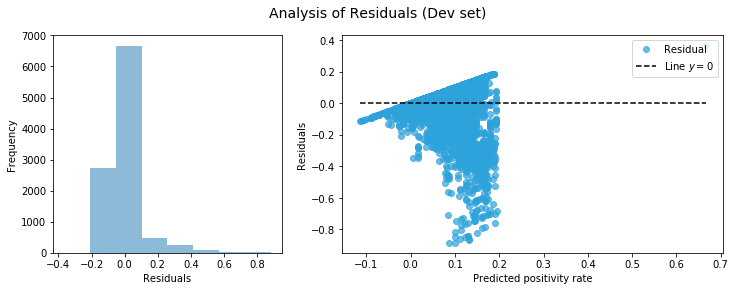

In [135]:
# sort the values of x before line plot
residuals = ydev - y_dev_pred

# plot the histograms of residuals
fig, ax = plt.subplots(1,2, figsize = (12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 5]) 
ax[0] = plt.subplot(gs[0])
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')
ax[0].hist(residuals, alpha = 0.5, bins=8)

# plot the predictions vs residuals
ax[1] = plt.subplot(gs[1])
ax[1].plot(y_dev_pred, y_dev_pred - ydev,'o',color='#2ea2db',alpha=0.7,label = 'Residual')
ax[1].plot([y_dev_pred.min(),y_dev_pred.max()],[0,0],'k--',label = 'Line $y=0$')
ax[1].set_xlabel('Predicted positivity rate',fontsize=10)
ax[1].set_ylabel('Residuals',fontsize=10)
ax[1].legend(loc='upper right',fontsize=10)
fig.suptitle('Analysis of Residuals (Dev set)',fontsize=14);

Our residuals are not quite normally distributed - when we make predictions, we tend to be pretty close, and we tend to overestimate rather than underestimate. There is some pattern in how far off we are, which means our predictors are likely linearly dependent. However, we knew this going in, since more strict governments are likely to impose multiple restrictions. This is an attribute of our data that we can't necessarily remove. We'll continue, knowing that some of our features are dependent and thus have less predictive power.

Note that there's also a large outlier that was predicted to have a positivity rate of 0.68, while most predictions are <0.25. Inspecting that particular outlier, we see that it's Nigeria in April 2020.

In [134]:
np.argmax(y_dev_pred)
xdev.iloc[8428]

CountryName                                 Nigeria
Date                                     2020-04-28
C1_School closing                                 3
C1_Flag                                           1
C2_Workplace closing                              3
C2_Flag                                           0
C3_Cancel public events                           2
C3_Flag                                           0
C4_Restrictions on gatherings                     4
C4_Flag                                           0
C5_Close public transport                         2
C5_Flag                                           0
C6_Stay at home requirements                      2
C6_Flag                                           0
C7_Restrictions on internal movement              2
C7_Flag                                           1
C8_International travel controls                  4
E1_Income support                                 1
E1_Flag                                           0
E2_Debt/cont

In [136]:
coefs = pd.DataFrame(lreg.coef_[::2], columns=['Coefficients'], index=features[::2])
coefs

Coefficients
C1_School closing                      1.763501e-02
C2_Workplace closing                   9.798460e-03
C3_Cancel public events                2.480511e-05
C4_Restrictions on gatherings          2.350807e-03
C5_Close public transport              5.265940e-03
C6_Stay at home requirements           9.990731e-03
C7_Restrictions on internal movement   4.267121e-03
C8_International travel controls      -1.315824e-02
E1_Flag                                6.048114e-03
E3_Fiscal measures                    -7.569490e-14
H1_Public information campaigns        2.596885e-03
H2_Testing policy                     -9.742492e-03
H4_Emergency investment in healthcare  3.680263e-13
H6_Facial Coverings                    1.804179e-02
H7_Vaccination policy                  8.134758e-03

Analyzing the coefficients here, it makes sense that they have low values to predict a positive rate between 0 and 1. It's surprising that some of them have positive coefficients, like *Workplace closing*, which suggests that a mandatory closing of all sectors except healthcare (aka a Workplace closing value of 3.0) can lead to a 0.029 _increase_ in the positivity rate.

Overall, it seems from this simple model that the only effective measures at decreasing positivity rate are 1) international travel controls, 2) fiscal measures, and 3) testing policy.

One weakness of this model is that it's capable of predicting values outside of our range, aka below 0 or above 1. By inspecting the min and max predictions, we see that all predictions are between -0.11461157479936748 and 0.6658185205482644, which is mostly reasonable except for a few negative values.

In [137]:
y_dev_pred.min(), y_dev_pred.max()

(-0.11461157479936748, 0.6658185205482644)